# Part 1: Fitting models

Math secretly has developed a lot of useful methods and ideas to work with numbers. The key is to become literate enough in both Math and Computer Science to apply it to real world data. This notebook will help you develop this literacy by learning how mathematical models can be *fitted* to data and how simple inferences can be made.

## Generative models

Sometimes in the world you are presented with lots of one type of data. For instance, how many letters arrive in your email per day, how much time elapses between subsequent busses in a bus stop. According to this data you might have to make some decisions like how much time to dedicate each day to reading your inbox and how much more you need to wait in a bus stop. If you are running a bussiness, analogous decisions become more important and thus should be informed by data.
 
Lets start with a simple example. This is a data set of how many emails I got per day for 10 different days. (How many of them were important is another question...)

In [ ]:
# import useful packages 
import numpy as np
import math
import matplotlib.pyplot as plt

# initialise data list
xs = [5, 6, 10, 2, 7, 3, 1, 1, 2, 1]

This data is quite simple. It does not have any response variable - for instance how many minutes I spent looking through my emails that day. Analysis you do on this type of data is called *unupervised machine learning*. Using this data we can find patterns. In particular, with this dataset we will explore the question of how many emails I can expect to get in the future. 

A particular kind of interesting patterns data scientist often look for are clusters. Often the data you are looking at contains measurements from multiple groups mixed together. The more data there is the harder it is for human scientist to find the boundaries between groups. Generative modelling can deal with it and furthermore tell us how "confident" we should be about the generated boundaries. 



### First step

In the meantime, lets back to the simple email example. 

We will call our random variable $X$ and it represents how many letters I got in a day.

The model we can try to fit to this data is Poisson distribution. You can read more about it [here](https://en.wikipedia.org/wiki/Poisson_distribution). The most important thing is its probability mass function which can be expressed as:

$$ Pr_X(x) = \frac{\lambda ^x e^{-\lambda}}{x!}$$

$\lambda$ is the unknow parameter that we want to estimate to know how likely are future values of $X$. If you actually opened the link, you might notice that $\lambda$ has to be greater than zero. This is an important constraint that we will return to later! 

I will write the probability mass function to make explicit the fact that $x$ depends on  $\lambda$:

$$ Pr_X(x|\lambda) = \frac{\lambda ^x e^{-\lambda}}{x!}$$

You should read that as the probability of a particular value of $x$ given $\lambda$. "|" symbol does not denote conditional probability but it is a common notation to express dependency.

We will view the entire data set `xs` as independent samples generated from this distribution.

To summarise this step, we need to pick a model (in our case, a distribution) with some tunable parameters that we will fit to the data. Also, we need to check and keep in mind the constraints.

#### Aside: Why the constaints are important?

The probability mass function expression might still have values when parameters like $\lambda$ do not obey the constraints. When it comes time to report the results of your analysis, you will have to explain why the model you choose makes sense. For instance, Poisson model has an interpretation that it closely models the number of independant events over an interval. So, we will have no problem defending this choice for emails. However, if we get a value of $\lambda$ that does not obey Poisson constraints, we cannot with clean conscience use mathematical results to support our model choice. Without the constraints, we are dealing with a totally different class of functions!


### Second step 

Now we need a function to calculare the likelihood of particular value of $\lambda$ given our data set. This is the same as plugin in $\lambda$  into our model and seeing how probable our dataset becomes.

$$lik(\lambda | x_1, ..., x_{10}) = Pr(x_1, ..., x_{10} | \lambda)$$

By the assumption that samples are independent, we can conclude:

$$Pr(x_1, ..., x_{10} | \lambda) = Pr_X(x_1 | \lambda) \times ... \times Pr_X(x_{10} | \lambda)$$

At this point your inner alarm bells should be ringing - probabilities tend to be quite small numbers and we are multiplying a bunch of them together. So to be safe, lets bring our trusted tool - the logarithm $\dagger$:

$$log(lik(\lambda | x_1, ..., x_{10})) = log(Pr_X(x_1 | \lambda) \times ... \times Pr_X(x_{10} | \lambda)) = log(Pr_X(x_1 | \lambda)) + ... + log(Pr_X(x_{10} | \lambda))$$ 

Our ultimate goal is to find the value for $\lambda$ that maximises the data sets likelihood. So using logarithm is OK as it is *monotonic* (i.e. we will still be able to distinguish higher likelihood value from the smaller one).

Using the rules of logarithm we can simplify the probability mass function $Pr_X(x|\lambda)$:

$$log(Pr_X(x|\lambda)) = log(\frac{\lambda ^x e^{-\lambda}}{x!}) = x \times log(\lambda) - \lambda - log(x!)$$

Thus, in this step we use independence assumption to find an expression for the log likelihood of our unknown parameters.

We can now write down likelihood function programatically.

In [ ]:
def fact(x):
  if x == 1:
    return x
  return x * fact(x-1)

def logPr_X(x, l): #l stands for lamda
  return x * math.log(l) - l - math.log(fact(x))

def loglik(l): # l - lambda, xs - our data set
  prx = [logPr_X(x,l) for x in xs] # xs is defined globaly - do not need to pass it as an argument
  return sum(prx) # return the sum of all log(Pr_X)'s

### Third step

We can now find the $\lambda$ that maximises the log likelihood expression. We can use calculus for that - find derivative and so on. But we can also use Computer Science. In particular we can use a function `scipy.optimize.fmin`. It takes a function with $n$ arguments and an initial guess (a list of size $n$) and returns the values for those arguments that minimise the function (also a list of size $n$). 
You might be confused - why would we want to minimise the function. Sadly, there is no `fmax` function, so we will maximise our log-likelihood function by taking its negative value. 

This is also the point where we bring our constraints associated with the model. `fmin` minimises the parameters over real numbers. But we need that $\lambda$ be in $(0; \infty)$. How good would it be to have a function that converts between real numbers and positive numbers which preserves ordering...

I am sure that at this point you are screaming at the screen '*Exponential!*'.

To use it, firstly we need to introduce temporary parameter $t$ that we will actually be using `fmin` with. Then we express $\lambda$ in terms of it:

$$\lambda = e^t$$

We will use when defining a helper function and then to recover the final result.

Word of caution: `fmin` is not a panacea, it can get stuck in local minima so give it a good initial guess if you can. 

Summary of this step: use numerical optimisation techniques to find values for parameters that maximise the likelihood. Remember to apply constraints.

In [ ]:
import scipy.optimize

def f(t):
  l = math.exp(t)
  return -loglik(l)

initial_guess = 2

t = scipy.optimize.fmin(f, initial_guess)

λ = math.exp(t)
print(λ)

Optimization terminated successfully.
         Current function value: 25.444330
         Iterations: 15
         Function evaluations: 30
3.7998475119767394


### Overview

You just fitted a model! Having learned the hidden parameter you can draw further inferences. The graph of the probability mass function looks pretty much right - majority of our samples is in the left side of the range where there is more probability mass.

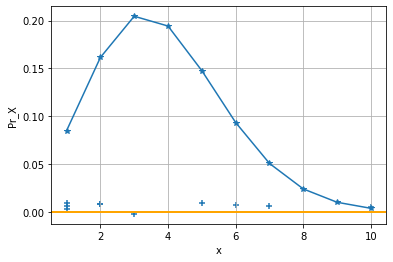

In [ ]:
step = [i + 1 for i in range(10)]
poisson = [math.exp(logPr_X(i, λ)) for i in step]

fig, ax = plt.subplots()
jitter_y = np.random.uniform(low=-0.01, high=0.01, size=len(xs))
ax.axhline(y=0, color='orange', linewidth='2')
ax.scatter(xs, jitter_y, marker='+')
ax.plot(step, poisson, marker='*')

ax.set(xlabel='x', ylabel='Pr_X')
ax.grid()


plt.show()

### More Advanced Example

That was cool, lets do it again! This time we will try to find clusters in a data using Gaussian Mixture Model.

Lets get acquainted with the data. Here are test scores of 82 students. Clusters in this dataset might indicate that there exist some teaching/learning disparities. Lets investigate it further! 

In [ ]:
 scores = [
 91, 93, 94, 95, 97, 102, 104, 160, 161, 184, 185, 186, 189,
 190, 190, 193, 193, 193, 194, 194, 195, 195, 195, 196, 198,
 198, 198, 199, 199, 199, 199, 201, 201, 201, 201, 202, 202,
 204, 206, 207, 208, 208, 208, 209, 211, 214, 217, 218, 219,
 219, 221, 222, 222, 222, 223, 223, 224, 227, 227, 228, 229,
 232, 232, 232, 234, 235, 235, 236, 237, 237, 241, 242, 242,
 243, 247, 249, 256, 266, 269, 320, 327, 342]

**Exercise 2.1** Get acquainted with the data. Your first task is to plot the data points on an axis (similarly to the plot above). Here is the code to get you started (you might also want to pass `alpha=0.6` parameter to `scatter` function). How many clusters do you expect?

In [ ]:
fig, ax = plt.subplots(figsize = (8,0.3))
jitter_y = # create random jitter in y direction - it will be easear to see the point 
# use ax.scatter to paint the points

plt.show()

### First step

The model we are going to fit assumes that we are looking into multiple groups mixed together - each with their characteristic Normal (Gaussian) distribution. We will try to identify three clusters (this choice is somewhat arbitrary, you will explore different choices in a later exercise).

The model depends on nine parameters:
*   $p_1$ - probability that the sample belongs to cluster 1 
*   $m_1$ - mean of the 1st cluster's normal ("normal" is short for "normal distribution")
*   $s_1$ - standard deviation of the 1st cluster's normal

And similarly $p_2$, $m_2$, $s_2$, $p_3$, $m_3$, $s_3$.

The probability density is thus the probability that $x$ belongs to cluster 1 or to cluster 2 or to cluster 3:

$Pr_X(x | p_1,m_1,s_1,p_2,m_2,s_2,p_3,m_3,s_3) 
= P(x$ belongs to cluster 1$) + P(x$ belongs to cluster 2$) + P(x$ belongs to cluster 3$) = p_1\times Pr_{Normal}(x | m_1, s_1) + p_2\times Pr_{Normal}(x | m_2, s_2) + p_3\times Pr_{Normal}(x | m_3, s_3)$

Here $Pr_{Normal}$ is just probability density of a normal distribution:

$$Pr_{Normal}(x | \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}}exp(\frac{-(x-\mu)^2}{2\sigma^2})$$

Just don't forget about constraints!

$$p_1, p_2, p_3 \in [0; 1]$$
$$p_1 + p_2 + p_3 = 1$$
$$s_1, s_2, s_3 \in [0; \infty)$$

**Exercise 2.2** Write down the function for $log(Pr_X(x | p_1,p_2,p_3,m_1,m_2,m_3,s_1,s_2,s_3))$. The parameters are given in a list L. For normal distribution density you can use Pr_N(x, m, s) function that I have handily provided! 

In [ ]:
import scipy.stats
Pr_N = scipy.stats.norm.pdf

def logPr_X(x, L):
  [p1, p2, p3, m1, m2, m3, s1, s2, s3] = L
  # You code goes here

### Second Step

Time to express our log likelihood function! 

**Exercise 2.3** Write a function for log likelihood of the parameters (given as a list L like in the function `logPr_X`).

In [ ]:
def loglik(L):
  # Your code goes here

### Third step

We can now use numerical optimisation to estimate the parameters for the distribution.

As you know, this is the point that constraints come in. I am sure that you will be able to deal with $s_1, s_2, s_3$ now, but what about $p_1, p_2, p_3$?

Firstly for $p_i \in [0; \infty)$ we can bring back our good friend exponential and a new temporary variable $q_i$. Then set:

$$p_i = \frac{e^{q_i}}{e^{q_i} + 1}$$

Then when $q_i$ is a very big number, then the denomerator becomes only slithly bigger then numerator, so $p_i$ gets very close to $1$ - and never greater than $1$.

Conversely, when $q_i$ is a very big negative number, $e_{q_i}$ becomes a very small positive number. 

$$p_i = \frac{e^{-\infty}}{e^{-\infty} + 1} \approx \frac{0}{0+1} \approx 0$$

So we are good! 

For the sum constraint $p_1 + p_2 + p_3 = 1$ we can express one of $p_i$ in terms of others, like so:

$$p_3 = 1 - p_1 - p_2 = 1 - \frac{e^{q_1}}{e^{q_1} + 1} - \frac{e^{q_2}}{e^{q_2} + 1}$$

However, right now $p_3$ can become negative, so we will need to readjust $p_1$ and $p_2$, but the idea remains the same:

$$p_1 = \frac{e^{q_1}}{e^{q_1} + e^{q_2} + 1}$$

$$p_2 = \frac{e^{q_2}}{e^{q_1} + e^{q_2} + 1}$$

$$p_3 = \frac{1}{e^{q_1} + e^{q_2} + 1}$$

The task now is to correctly express it for numerical optimisation!

**Exercise 2.4** Write a function f(T) where T is a list of parameters `[q1, q2, m1, m2, m3, t1, t2, t3]` that expresses the function we are trying to minimise using `loglik` function defined earlier. When the optimisation terminates recover the formal parameters from the temporary ones.

In [ ]:
def f(T):
  [q1, q2, m1, m2, m3, t1, t2, t3] = T
  # Your code goes here

initial_guess = [-1,-1, 100,200,240, math.log(10),math.log(50),math.log(80)]

t = scipy.optimize.fmin(f, initial_guess, maxiter=4000)

# Recover formal parameters:
[q1, q2, m1, m2, m3, t1, t2, t3] = t

# And here

L = [p1, p2, p3, m1, m2, m3, s1, s2, s3]

Time to generate the final graph and think what the results mean. Maybe the students in the different groups belong to different schools, different social groups, what causes the difference in test performance - there are a lot of questions that could follow your analysis! 

**Exercise 2.5** Generate the graph for the probability distribution. Use your code from earlier to add the data-points to the graph. This is the graph that I get:

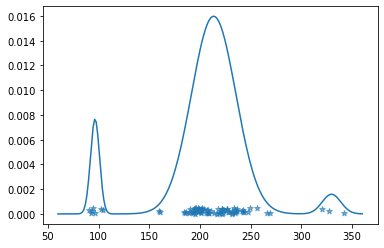

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(60,360,200)

#Your code goes here

plt.show()

**Exercise 2.6** Use the same `scores` data set to fit Gaussian mixture model with either 2 or 4 (you choose!) clusters. Which model is a better fit - the 3-cluster model or your model? How do you know?

## Supervised learning and linear regression

https://osp.stat.gov.lt/statistiniu-rodikliu-analize?indicator=S4R125#/
